In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image, make_grid
import logging
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
import os
import pickle
import logging
import copy
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VAE_MNIST(nn.Module):
  def __init__(self, x_dim, h1_dim, h2_dim, z_dim):
    super(VAE_MNIST, self).__init__()
    self.FC1 = nn.Linear(x_dim + 10, h1_dim)
    self.FC2 = nn.Linear(h1_dim, h2_dim)
    self.FC3_mu = nn.Linear(h2_dim, z_dim)
    self.FC3_sigma = nn.Linear(h2_dim, z_dim)

    self.FC4 = nn.Linear(z_dim + 10, h2_dim)
    self.FC5 = nn.Linear(h2_dim, h1_dim)
    self.FC6 = nn.Linear(h1_dim, x_dim)

    self.z_dim = z_dim

  def encoder(self, x, one_hot_class):
    x = torch.cat((x, one_hot_class), 1)
    x = F.relu(self.FC1(x))
    x = F.relu(self.FC2(x))
    mu = self.FC3_mu(x)
    sigma = self.FC3_sigma(x)
    return mu, sigma
  def decoder(self, z, one_hot_class):
    x = torch.cat((z, one_hot_class), 1)
    x = F.relu(self.FC4(x))
    x = F.relu(self.FC5(x))
    x = torch.sigmoid(self.FC6(x))
    return x
  def sampler(self, mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + sigma * eps
  def forward(self, x, one_hot_class):
    mu, sigma = self.encoder(x.view(-1,784), one_hot_class)
    z = self.sampler(mu, sigma)
    x = self.decoder(z, one_hot_class)
    return x, mu, sigma
  def info_vae(self):
    return self.z_dim

In [ ]:
def loss_function(x, x_hat, mu, sigma):
  BCE = F.binary_cross_entropy(x_hat, x.view(-1,784), reduction='sum')
  KLD = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
  return BCE + KLD
def train(model, num_batch_iter, train_iter, optimizer, logging_freq, test_loader):
  model.train()
  train_loss = 0
  for iter in tqdm(range(num_batch_iter)):
    x, cls = next(train_iter)
    one_hot_class = F.one_hot(cls, num_classes=10)
    x = x.to(device)
    one_hot_class = one_hot_class.to(device)
    optimizer.zero_grad()
    x_hat, mu, sigma = model(x, one_hot_class)
    loss = loss_function(x, x_hat, mu, sigma)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
    if iter % logging_freq == 0:
      model.eval()
      with torch.no_grad():
        z = torch.randn(10, model.info_vae()).to(device)
        c =  torch.arange(10)
        c = F.one_hot(c, num_classes=10).to(device)
        x_hat = model.decoder(z, c).view(10, 1, 28,28)
        grid = make_grid(x_hat, nrow = 10)
        save_image(grid, os.path.join("output/", "step_" + str(iter) + ".png"))
        np_grid = grid.detach().cpu().permute(1, 2, 0).numpy()

        plt.figure(figsize=(10, 10))
        plt.imshow(np_grid)
        plt.title(f'Step {iter}')
        plt.axis('off')
        plt.show()
def test(model,test_loader):
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for x, cls in test_loader:
      cls = F.one_hot(cls, 10)
      x = x.to(device)
      cls = cls.to(device)
      x_hat, mu, sigma = model(x, cls)
      test_loss += loss_function(x, x_hat, mu, sigma).item()
  return test_loss/len(test_loader)
def cycle(dl):
  while True:
      for data in dl:
          yield data

In [ ]:
train_dataset = datasets.MNIST(root="data/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="data/", train=False, transform=transforms.ToTensor(), download=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)
train_iter = cycle(train_loader)
vae = VAE_MNIST(x_dim=28 * 28, h1_dim= 512, h2_dim=256, z_dim=8)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.0001)



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


In [ ]:
n_iters = 100000
log_freq = 5000
train(vae, n_iters, train_iter, optimizer, log_freq, test_loader)
print("Training complete. Saving model...")
MODEL_PATH = "vae_mnist_final.pth"
torch.save(vae.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

In [ ]:
def calculate_fim(model, n_samples):
  fisher_diag = {}
  for name, param in model.named_parameters():
      fisher_diag[name] = torch.zeros_like(param.data)
  model.eval()
  for i in range(n_samples):
    with torch.no_grad():
      z = torch.randn(1, model.info_vae()).to(device)
      c =  torch.randint(0,10, (1,))
      c = F.one_hot(c, num_classes=10).to(device)
      model.eval()
      x = model.decoder(z, c)
    model.train()
    model.zero_grad()
    x_hat, mu, sigma = vae(x, c)
    loss = loss_function(x, x_hat, mu, sigma)
    loss.backward()
    for name, param in model.named_parameters():
      if torch.isnan(param.grad.data).any():
        print("NAN")
      fisher_diag[name] += ((param.grad.data).pow(2) ) / n_samples
  with open(os.path.join("output/", 'fisher_diag.pkl'), 'wb') as f:
        pickle.dump(fisher_diag, f)
  return fisher_diag

In [ ]:
fisher_dict = calculate_fim(vae, 50000)

In [ ]:
def forget_train(model, num_batch_iter, optimizer, logging_freq, drop_labels, fisher_dict, params_mle_dict, lmbda):
  model_dup = copy.deepcopy(model)
  model_dup.eval()
  label_choices = list(range(10))
  for label in drop_labels:
    label_choices.remove(label)
  model.train()
  for iter in tqdm(range(num_batch_iter)):
    loss = 0
    c_remember = torch.from_numpy(np.random.choice(label_choices, size=256)).to(device)
    c_remember = F.one_hot(c_remember, 10)
    z_remember = torch.randn((256, 8)).to(device)
    for drop_label in drop_labels:
      c_forget = (torch.ones(256, dtype=int) * drop_label).to(device)
      c_forget = F.one_hot(c_forget, 10)
      out_forget = torch.rand((256, 1, 28, 28)).to(device)
      with torch.no_grad():
        out_remember = model_dup.decoder(z_remember, c_remember).view(-1,1,28,28)
      optimizer.zero_grad()
      x_hat, mu, sigma = model(out_forget, c_forget)
      loss += loss_function(out_forget, x_hat, mu, sigma)

    x_hat, mu, sigma = model(out_remember, c_remember)
    loss += loss_function(out_remember,x_hat, mu, sigma)
    for name, param in model.named_parameters():
      fish_loss = fisher_dict[name].to(device) * (param - params_mle_dict[name].to(device)).pow(2)
      loss += lmbda * fish_loss.sum()
    if iter % logging_freq == 0:
      model.eval()
      with torch.no_grad():
        z = torch.randn(10, model.info_vae()).to(device)
        c =  torch.arange(10)
        c = F.one_hot(c, num_classes=10).to(device)
        x_hat = model.decoder(z, c).view(10, 1, 28,28)
        grid = make_grid(x_hat, nrow = 10)
        save_image(grid, os.path.join("output/", "step_" + str(iter) + ".png"))
        np_grid = grid.detach().cpu().permute(1, 2, 0).numpy()

        plt.figure(figsize=(10, 10))
        plt.imshow(np_grid)
        plt.title(f'Step {iter}')
        plt.axis('off')
        plt.show()
    loss.backward()
    optimizer.step()

In [ ]:
MODEL_PATH = "vae_mnist_final.pth"
vae.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
MODEL_PATH_UNLEARNED = "vae_mnist_final_unlearned.pth"
vae.load_state_dict(torch.load(MODEL_PATH_UNLEARNED, map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
with open(os.path.join('fisher_diag.pkl'), 'rb') as f:
  fisher_dict = pickle.load(f)
params_mle_dict = {}
for name, param in vae.named_parameters():
    params_mle_dict[name] = param.data.clone()

  0%|          | 0/10000 [00:00<?, ?it/s]

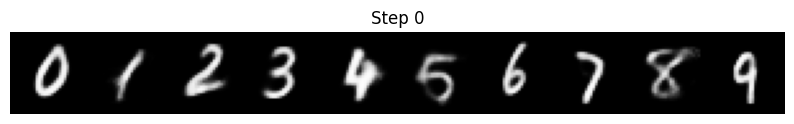

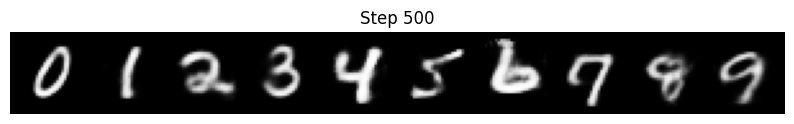

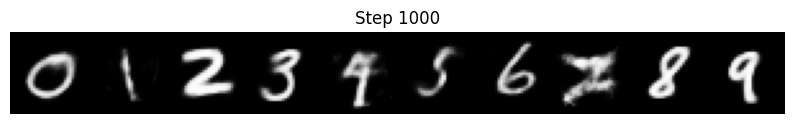

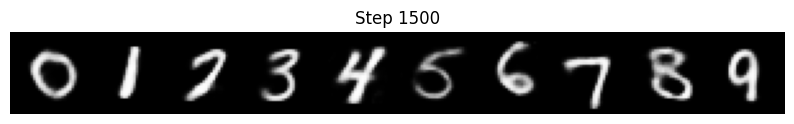

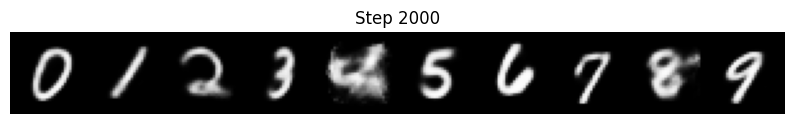

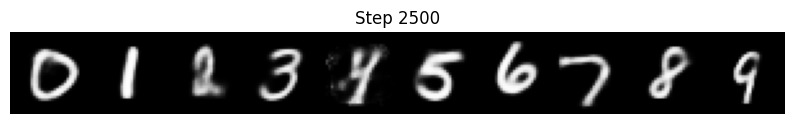

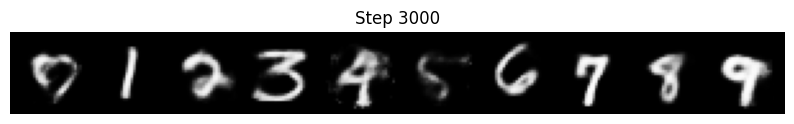

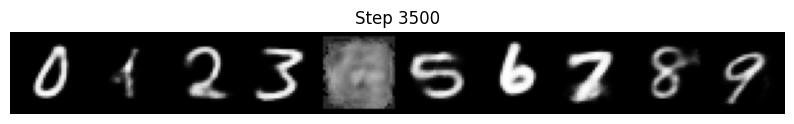

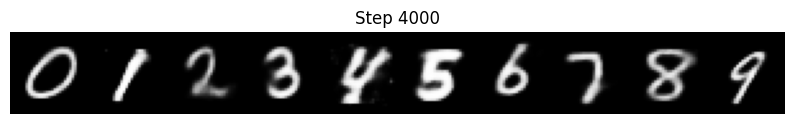

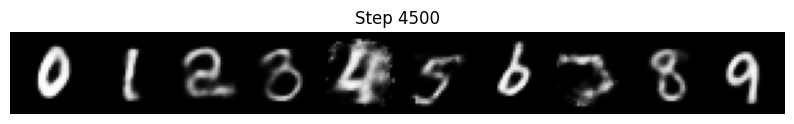

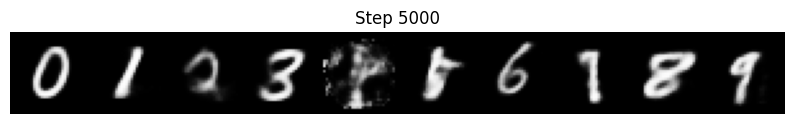

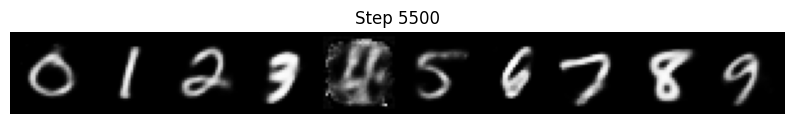

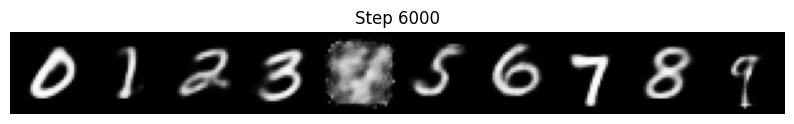

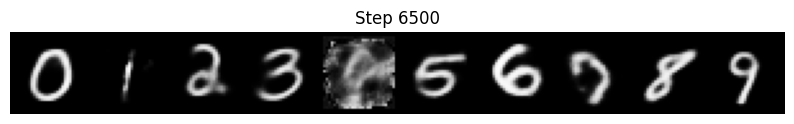

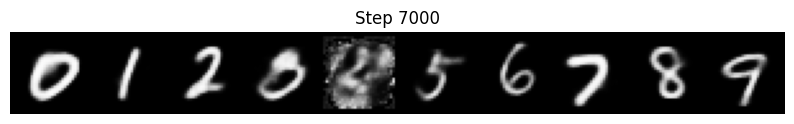

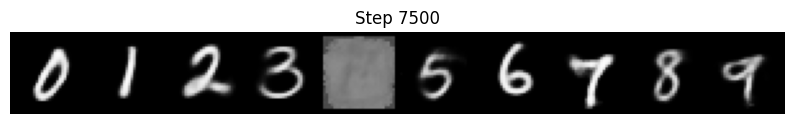

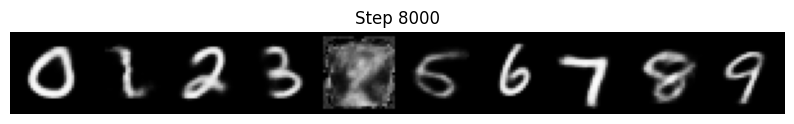

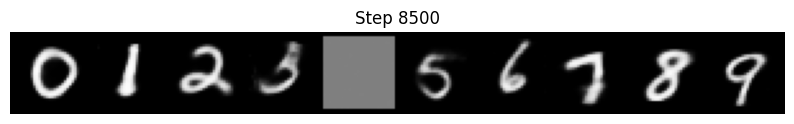

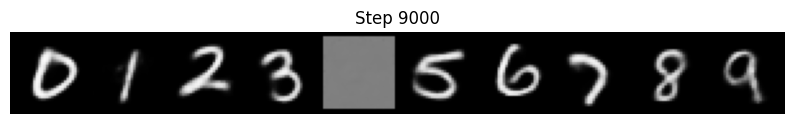

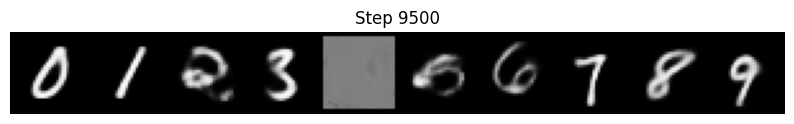

In [ ]:
lmbda = 100
n_iter = 10000
freq = 500
lr = 0.0001
forget_train(vae, n_iter, optimizer, freq, [4], fisher_dict, params_mle_dict, lmbda)

In [ ]:
MODEL_PATH_UNLEARNED = "vae_mnist_final_unlearned.pth"
torch.save(vae.state_dict(), MODEL_PATH_UNLEARNED)

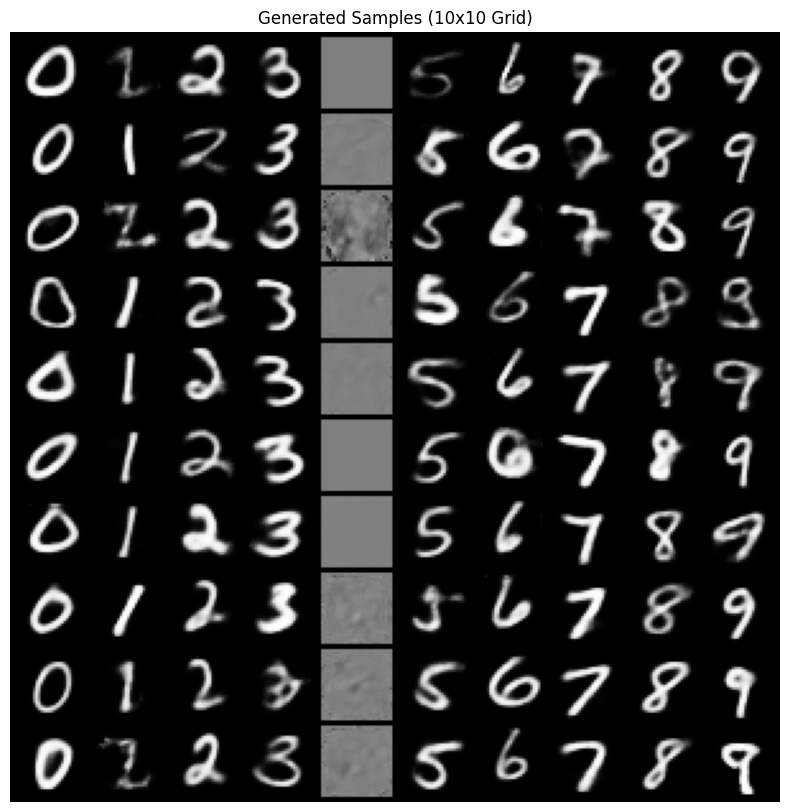

In [ ]:
def sample():
    vae.eval()
    with torch.no_grad():
        z = torch.randn((100, 8)).to(device)
        c = torch.arange(10).to(device)
        c = c.repeat(10)

        c = F.one_hot(c, 10)

        out = vae.decoder(z, c).view(-1, 1, 28, 28)

        grid = make_grid(out, nrow = 10)
        save_image(grid, os.path.join("output/", "grid" + ".png"))

        np_grid = grid.detach().cpu().permute(1, 2, 0).numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(np_grid)
        plt.title('Generated Samples (10x10 Grid)')
        plt.axis('off')
        plt.show()

sample()

Running t-SNE... (this may take a minute)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


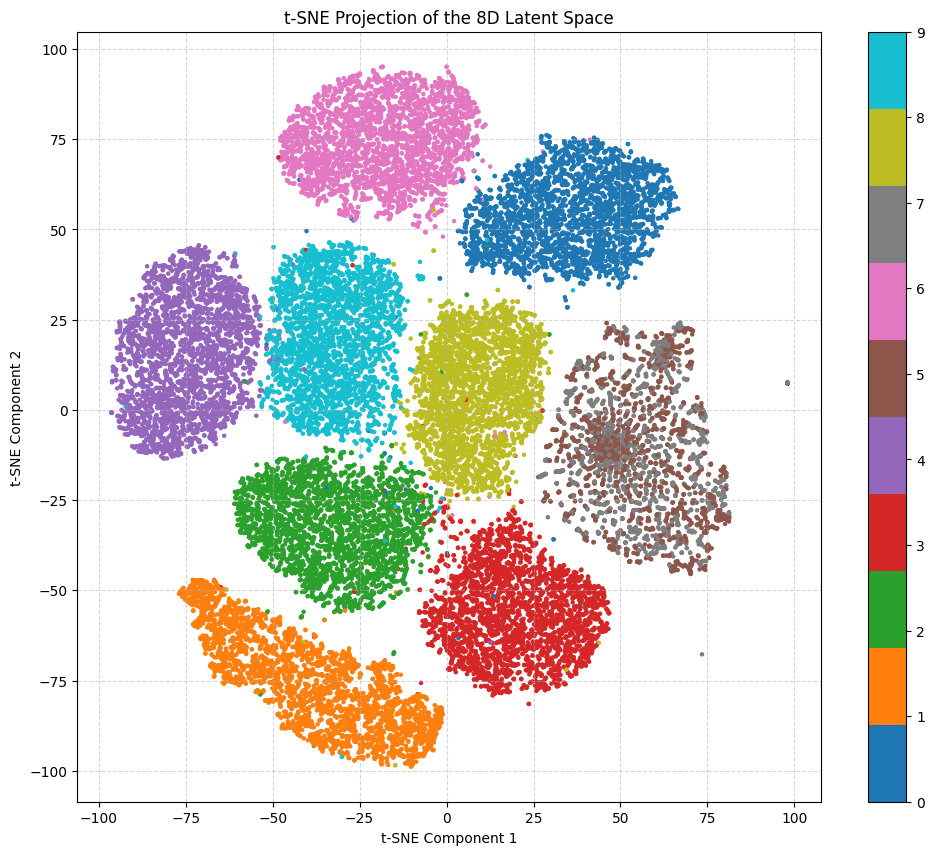

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_latent_space(model, n_samples):
    model.eval()
    all_x = []
    all_labels_indices = []

    with torch.no_grad():
        for iter in range(n_samples):
            z = torch.randn(10, model.info_vae()).to(device)

            c_indices =  torch.arange(10)
            c_one_hot = F.one_hot(c_indices, num_classes=10).to(device)

            x_hat = model.decoder(z, c_one_hot).view(10, 1, 28, 28)

            all_x.append(x_hat.cpu().numpy())
            all_labels_indices.append(c_indices.cpu().numpy())

    all_x = np.concatenate(all_x, axis=0)
    all_labels = np.concatenate(all_labels_indices, axis=0)

    n_samples_total = all_x.shape[0]
    all_x_flat = all_x.reshape(n_samples_total, -1)
    print("Running t-SNE... (this may take a minute)")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    z_2d = tsne.fit_transform(all_x_flat)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=all_labels, cmap='tab10', s=5)

    plt.colorbar(scatter, ticks=range(10))
    plt.title("t-SNE Projection of the 8D Latent Space")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

visualize_latent_space(vae, 4000)

Running t-SNE... (this may take a minute)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


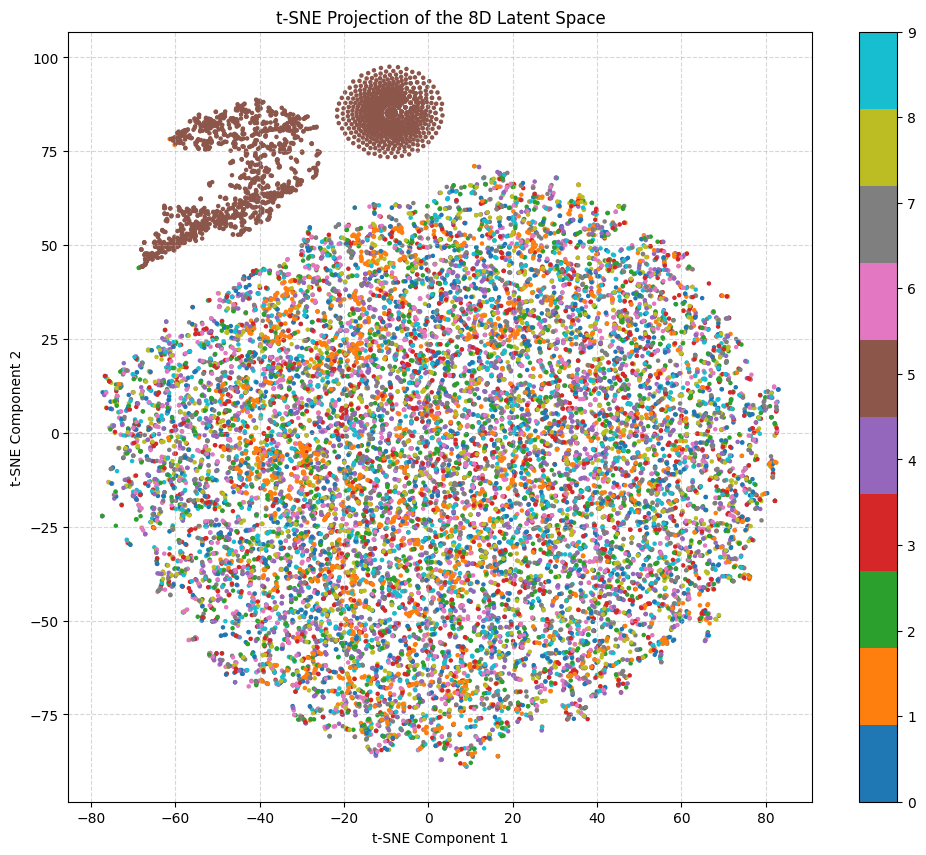

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def visualize_latent_space(model, n_samples):
    model.eval()
    all_z_mu = []
    all_labels_indices = []

    with torch.no_grad():
        for iter in range(n_samples):
            z = torch.randn(10, model.info_vae()).to(device)

            c_indices =  torch.arange(10)
            c_one_hot = F.one_hot(c_indices, num_classes=10).to(device)

            x_hat = model.decoder(z, c_one_hot).view(10, 1, 28, 28)
            mu, sigma = model.encoder(x_hat.view(-1, 784), c_one_hot)

            all_z_mu.append(mu.cpu().numpy())
            all_labels_indices.append(c_indices.cpu().numpy())

    all_z_mu = np.concatenate(all_z_mu, axis=0)
    all_labels = np.concatenate(all_labels_indices, axis=0)

    print("Running t-SNE... (this may take a minute)")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    z_2d = tsne.fit_transform(all_z_mu)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=all_labels, cmap='tab10', s=5)

    plt.colorbar(scatter, ticks=range(10))
    plt.title("t-SNE Projection of the 8D Latent Space")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

visualize_latent_space(vae, 2000)

Starting Condition-Only Attack...


  0%|          | 0/3000 [00:00<?, ?it/s]

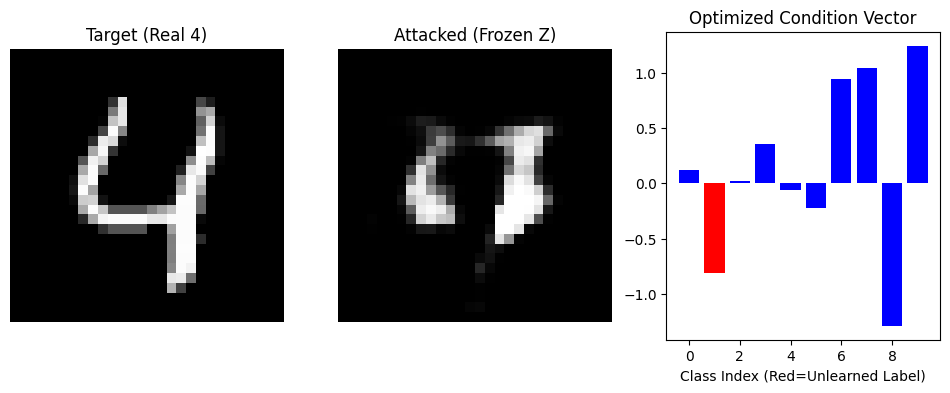

Condition-only attack complete.


In [ ]:
def attack_condition_only(model, target_image_tensor, num_steps=3000, lr=0.05):
    """
    Attacks the VAE by optimizing ONLY the condition vector (c).
    The latent vector (z) is fixed and random.
    """
    model.eval()

    target = target_image_tensor.to(device).view(1, 1, 28, 28)
    z_fixed = torch.randn(1, model.info_vae()).to(device)
    z_fixed.requires_grad = False
    c_adv = torch.randn(1, 10).to(device).requires_grad_(True)
    optimizer_attack = optim.Adam([c_adv], lr=lr)

    print("Starting Condition-Only Attack...")
    pbar = tqdm(range(num_steps))

    for i in pbar:
        optimizer_attack.zero_grad()

        generated_image = model.decoder(z_fixed, c_adv).view(1, 1, 28, 28)

        loss = F.mse_loss(generated_image, target)

        loss.backward()
        optimizer_attack.step()

        if i % 100 == 0:
            pbar.set_description(f"Loss: {loss.item():.6f}")

    with torch.no_grad():
        final_image = model.decoder(z_fixed, c_adv).view(1, 1, 28, 28)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(target.cpu().squeeze(), cmap='gray')
    axes[0].set_title("Target (Real 4)")
    axes[0].axis('off')

    axes[1].imshow(final_image.cpu().squeeze(), cmap='gray')
    axes[1].set_title("Attacked (Frozen Z)")
    axes[1].axis('off')

    c_np = c_adv.detach().cpu().numpy().flatten()
    colors = ['red' if i == 1 else 'blue' for i in range(10)]
    axes[2].bar(range(10), c_np, color=colors)
    axes[2].set_title("Optimized Condition Vector")
    axes[2].set_xlabel("Class Index (Red=Unlearned Label)")

    plt.show()

    return c_adv

target_img = None
for x, y in test_loader:
    idx = (y == 4).nonzero(as_tuple=True)[0]
    if len(idx) > 0:
        target_img = x[idx[0]]
        break

if target_img is not None:
    c_hacked_only = attack_condition_only(vae, target_img)

    print("Condition-only attack complete.")
else:
    print("Could not find a '1' in the current batch.")

Starting Parallel Attack on 256 random seeds...


  0%|          | 0/3000 [00:00<?, ?it/s]

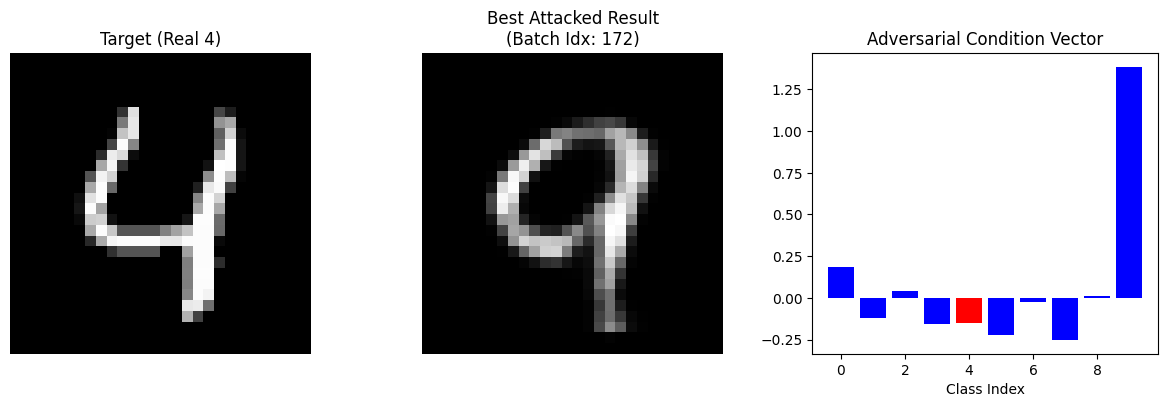

In [ ]:
def attack_parallel_condition(model, target_image_tensor, batch_size=128, num_steps=3000, lr=0.1):
    """
    Advanced Attack:
    1. Generates 'batch_size' different fixed z-codes.
    2. Optimizes a unique c-code for EACH z-code in parallel.
    3. Returns the single best reconstruction.
    """
    model.eval()
    target = target_image_tensor.to(device).view(1, 1, 28, 28)
    target_batch = target.repeat(batch_size, 1, 1, 1)
    z_fixed_batch = torch.randn(batch_size, model.info_vae()).to(device)
    z_fixed_batch.requires_grad = False
    c_adv_batch = torch.randn(batch_size, 10).to(device).requires_grad_(True)
    optimizer = optim.Adam([c_adv_batch], lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=200)

    print(f"Starting Parallel Attack on {batch_size} random seeds...")
    pbar = tqdm(range(num_steps))

    for i in pbar:
        optimizer.zero_grad()

        generated_batch = model.decoder(z_fixed_batch, c_adv_batch).view(batch_size, 1, 28, 28)

        loss_raw = (generated_batch - target_batch).pow(2)

        loss_per_sample = loss_raw.view(batch_size, -1).sum(dim=1)

        loss = loss_per_sample.mean()

        loss.backward()
        optimizer.step()
        best_current_loss = loss_per_sample.min().item()
        scheduler.step(best_current_loss)

        if i % 100 == 0:
            pbar.set_description(f"Best Loss: {best_current_loss:.4f}")
    with torch.no_grad():
        generated_final = model.decoder(z_fixed_batch, c_adv_batch).view(batch_size, 1, 28, 28)
        diff = (generated_final - target_batch).pow(2).view(batch_size, -1).sum(dim=1)
        best_idx = torch.argmin(diff).item()

        best_image = generated_final[best_idx]
        best_c = c_adv_batch[best_idx]
        best_z = z_fixed_batch[best_idx]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(target.cpu().squeeze(), cmap='gray')
    axes[0].set_title(f"Target (Real {target_label})")
    axes[0].axis('off')

    axes[1].imshow(best_image.cpu().squeeze(), cmap='gray')
    axes[1].set_title(f"Best Attacked Result\n(Batch Idx: {best_idx})")
    axes[1].axis('off')

    c_np = best_c.detach().cpu().numpy()
    colors = ['red' if k == target_label else 'blue' for k in range(10)]

    axes[2].bar(range(10), c_np, color=colors)
    axes[2].set_title("Adversarial Condition Vector")
    axes[2].set_xlabel("Class Index")

    plt.tight_layout()
    plt.show()

    return best_c, best_z

target_label = 4
target_img = None
for x, y in test_loader:
    idx = (y == target_label).nonzero(as_tuple=True)[0]
    if len(idx) > 0:
        target_img = x[idx[0]]
        break

if target_img is not None:
    c_hacked, z_fixed_winner = attack_parallel_condition(vae, target_img, batch_size=256, lr=0.1)
else:
    print(f"Could not find a {target_label} in the current batch.")